# AIRD ML Learning Examples

이 노트북은 3개의 ML Dataset을 사용하여 머신러닝 모델을 학습합니다.

**입력**:
- `data/processed/ml_factory_risk_seoul_2025_v1.csv`
- `data/processed/ml_region_old_factory_share_seoul_2025_v1.csv`
- `data/processed/ml_location_score_candidate_sites_v1.csv`

**출력**:
- `outputs/models/*.pkl` (학습된 모델)
- `outputs/figures/*.png` (성능 그래프)

In [ ]:
# colab 환경에서는 한글 폰트 설치 필요
# 설치 후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib
import warnings
import os
warnings.filterwarnings('ignore')

# 폰트 설정
import matplotlib.font_manager as fm


def set_korean_font():
    """
    플랫폼 판별 및 폰트 다운로드 없이
    matplotlib에 이미 설치된 한글 폰트만 사용
    """

    candidate_fonts = [
        "Malgun Gothic",      # Windows
        "AppleGothic",        # macOS
        "NanumGothic",        # Linux / 일부 Colab
        "Noto Sans CJK KR",
        "Noto Sans KR"
    ]

    installed_fonts = {f.name for f in fm.fontManager.ttflist}
    for font in candidate_fonts:
        if font in installed_fonts:
            plt.rcParams["font.family"] = font
            plt.rcParams["axes.unicode_minus"] = False
            print(f"✅ 한글 폰트 적용: {font}")
            return

# 실행
set_korean_font()

print("✅ 라이브러리 로드 완료")

# XGBoost 확인 (환경에 상관없이 안전하게)
XGBOOST_AVAILABLE = False

try:
    import xgboost as xgb
    # 내부 라이브러리 로딩 테스트 (libomp 오류 등 잡기 위함)
    try:
        _ = xgb.XGBClassifier()
        print(f"✅ XGBoost {xgb.__version__} 사용 가능")
        XGBOOST_AVAILABLE = True
    except Exception as e:
        print(f"⚠️  XGBoost 로딩 실패 (환경 문제): {e}")
        print("➡️  XGBoost 없이 진행합니다. Random Forest 사용.")
except ImportError:
    print("⚠️  XGBoost가 설치되어 있지 않습니다. Random Forest만 사용합니다.")

✅ 한글 폰트 적용: AppleGothic
✅ 라이브러리 로드 완료
✅ XGBoost 1.7.6 사용 가능


In [4]:
# 출력 폴더 생성
os.makedirs('outputs/models', exist_ok=True)
os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/reports', exist_ok=True)
print("✅ 출력 폴더 준비 완료")

✅ 출력 폴더 준비 완료


---
## Dataset 1: 공장 리스크 예측 (Classification)

**목표**: 공장의 리스크 레벨을 예측합니다.
**타겟**: `위험도등급` (이진 분류)

In [5]:
# Dataset 1 로드
print("="*60)
print("📊 Dataset 1: 공장 리스크 예측")
print("="*60)

df1 = pd.read_csv("../../data/processed/ml_factory_risk_seoul_2025_v1.csv")
print(f"\n데이터 크기: {df1.shape}")
print(f"컬럼: {list(df1.columns)[:5]}...")

# 타겟 컬럼 확인
target_col = None
for col in ['위험도등급', 'risk_level', 'target', '노후공장여부', 'label_high_risk']:
    if col in df1.columns:
        target_col = col
        break

if target_col is None:
    print("\n⚠️  타겟 컬럼을 찾을 수 없습니다. 노후공장여부를 생성합니다.")
    # 공장연령 기준으로 타겟 생성
    if '공장연령' in df1.columns:
        df1['노후공장여부'] = (df1['공장연령'] >= df1['공장연령'].quantile(0.75)).astype(int)
        target_col = '노후공장여부'
    else:
        print("❌ 공장연령 컬럼도 없습니다!")
        target_col = df1.columns[-1]  # 마지막 컬럼 사용

print(f"\n타겟 컬럼: {target_col}")
print(f"타겟 분포:\n{df1[target_col].value_counts()}")

📊 Dataset 1: 공장 리스크 예측

데이터 크기: (16192, 11)
컬럼: ['factory_id', 'company_name', 'region_gu', 'region_dong', 'feature_base_age']...

타겟 컬럼: label_high_risk
타겟 분포:
label_high_risk
0    12143
1     4049
Name: count, dtype: int64


In [6]:
# 데이터 준비
# 숫자형 컬럼만 선택
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()

# 타겟 제외
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

# Feature와 Target 분리
X = df1[numeric_cols].fillna(0)
y = df1[target_col]

print(f"\nFeature 개수: {X.shape[1]}")
print(f"Feature 예시: {X.columns[:5].tolist()}")

# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n학습 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")


Feature 개수: 7
Feature 예시: ['factory_id', 'feature_base_age', 'feature_base_area', 'feature_base_area_log', 'feature_base_gu_density']

학습 데이터: (12953, 7)
테스트 데이터: (3239, 7)


In [8]:
# 모델 1: Random Forest
print("\n" + "-"*60)
print("🌲 Random Forest 학습 중...")
print("-"*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

# 평가
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, rf_pred, average='weighted', zero_division=0)

print(f"\n✅ Random Forest 성능:")
print(f"   정확도: {rf_accuracy:.3f}")
print(f"   정밀도: {rf_precision:.3f}")
print(f"   재현율: {rf_recall:.3f}")
print(f"   F1 Score: {rf_f1:.3f}")

# 모델 저장
joblib.dump(rf_model, 'outputs/models/factory_risk_rf_model.pkl')
print(f"\n💾 모델 저장: outputs/models/factory_risk_rf_model.pkl")


------------------------------------------------------------
🌲 Random Forest 학습 중...
------------------------------------------------------------

✅ Random Forest 성능:
   정확도: 1.000
   정밀도: 1.000
   재현율: 1.000
   F1 Score: 1.000

💾 모델 저장: outputs/models/factory_risk_rf_model.pkl


In [9]:
# 모델 2: XGBoost (있는 경우)
if XGBOOST_AVAILABLE:
    print("\n" + "-"*60)
    print("🚀 XGBoost 학습 중...")
    print("-"*60)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    # 평가
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    xgb_precision = precision_score(y_test, xgb_pred, average='weighted', zero_division=0)
    xgb_recall = recall_score(y_test, xgb_pred, average='weighted', zero_division=0)
    xgb_f1 = f1_score(y_test, xgb_pred, average='weighted', zero_division=0)
    
    print(f"\n✅ XGBoost 성능:")
    print(f"   정확도: {xgb_accuracy:.3f}")
    print(f"   정밀도: {xgb_precision:.3f}")
    print(f"   재현율: {xgb_recall:.3f}")
    print(f"   F1 Score: {xgb_f1:.3f}")
    
    # 모델 저장
    joblib.dump(xgb_model, 'outputs/models/factory_risk_xgb_model.pkl')
    print(f"\n💾 모델 저장: outputs/models/factory_risk_xgb_model.pkl")
else:
    xgb_pred = rf_pred
    xgb_prob = rf_prob


------------------------------------------------------------
🚀 XGBoost 학습 중...
------------------------------------------------------------

✅ XGBoost 성능:
   정확도: 1.000
   정밀도: 1.000
   재현율: 1.000
   F1 Score: 1.000

💾 모델 저장: outputs/models/factory_risk_xgb_model.pkl



📊 시각화 생성 중...


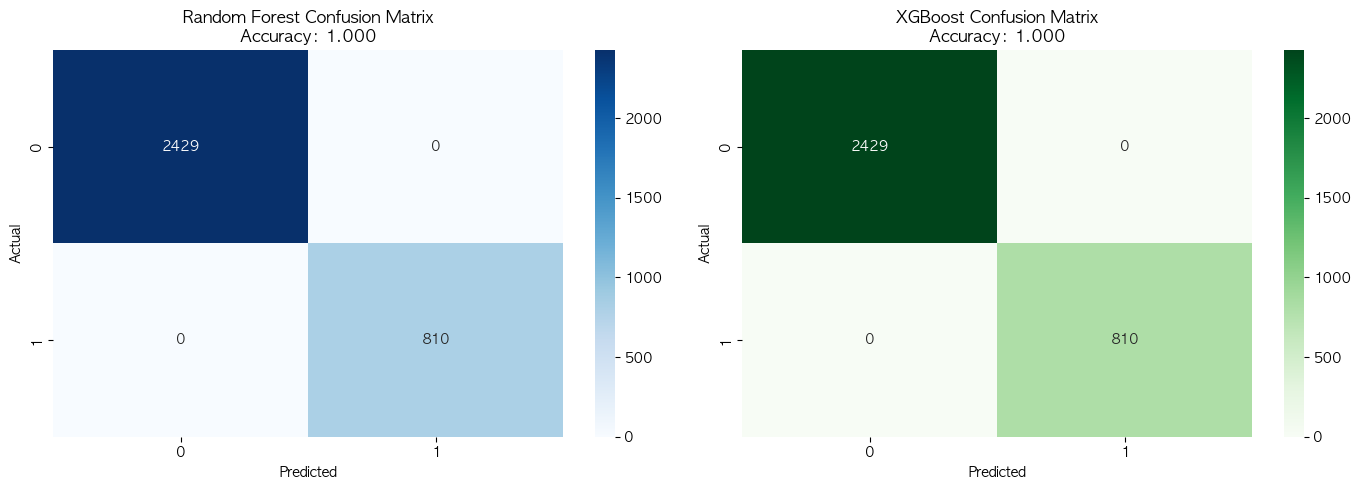

✅ 저장: outputs/figures/factory_confusion_matrix.png


In [10]:
# 시각화 1: Confusion Matrix
print("\n📊 시각화 생성 중...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Random Forest Confusion Matrix\nAccuracy: {rf_accuracy:.3f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# XGBoost
if XGBOOST_AVAILABLE:
    cm_xgb = confusion_matrix(y_test, xgb_pred)
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f'XGBoost Confusion Matrix\nAccuracy: {xgb_accuracy:.3f}')
else:
    axes[1].text(0.5, 0.5, 'XGBoost 미설치', ha='center', va='center', fontsize=20)
    axes[1].set_title('XGBoost (Not Available)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()
plt.savefig('outputs/figures/factory_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ 저장: outputs/figures/factory_confusion_matrix.png")





📊 Feature Importance 생성 중...


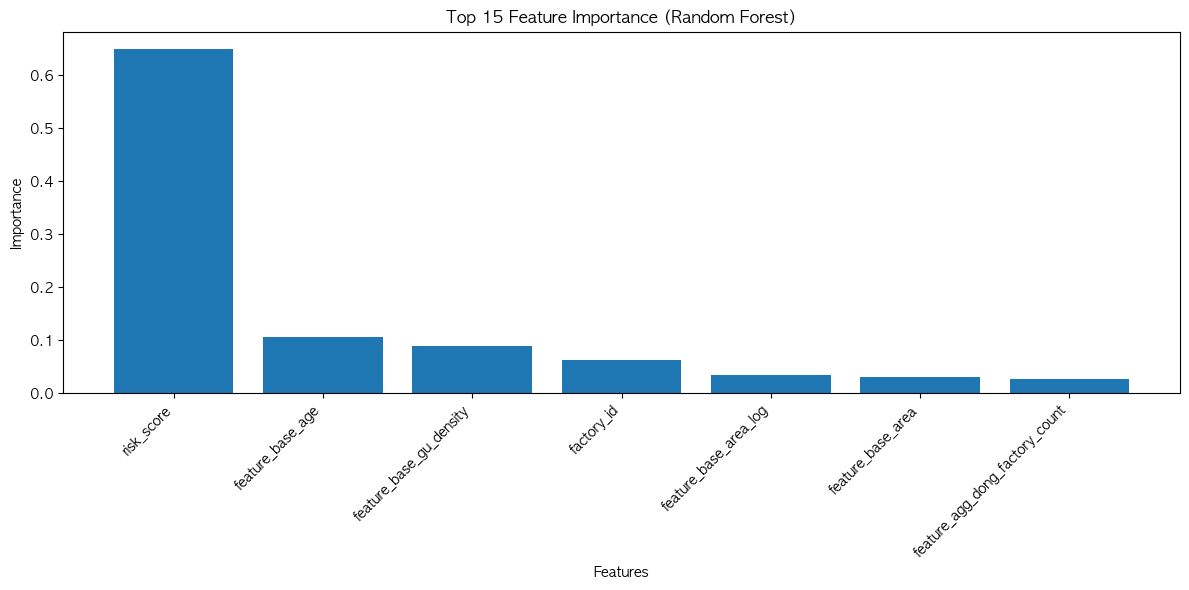

✅ 저장: outputs/figures/factory_feature_importance.png


In [11]:
# 시각화 2: Feature Importance
print("\n📊 Feature Importance 생성 중...")

# Random Forest Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # 상위 15개

plt.figure(figsize=(12, 6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=45, ha='right')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
plt.savefig('outputs/figures/factory_feature_importance.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ 저장: outputs/figures/factory_feature_importance.png")

In [12]:
# 시각화 3: ROC Curve
print("\n📊 ROC Curve 생성 중...")

plt.figure(figsize=(10, 6))

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
roc_auc_rf = roc_auc_score(y_test, rf_prob)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', linewidth=2)

# XGBoost ROC
if XGBOOST_AVAILABLE:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)
    roc_auc_xgb = roc_auc_score(y_test, xgb_prob)
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})', linewidth=2)

# 대각선
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Factory Risk Prediction')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/figures/factory_roc_curve.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ 저장: outputs/figures/factory_roc_curve.png")


📊 ROC Curve 생성 중...
✅ 저장: outputs/figures/factory_roc_curve.png


---
## Dataset 2: 자치구 노후공장 비중 (Regression)

**목표**: 자치구별 노후공장 비중을 예측합니다.

In [14]:
# Dataset 2 로드
print("\n" + "="*60)
print("📊 Dataset 2: 자치구 노후공장 비중")
print("="*60)

df2 = pd.read_csv("../../data/processed/ml_region_old_factory_share_seoul_2025_v1.csv")
print(f"\n데이터 크기: {df2.shape}")

# 타겟 찾기
target_col2 = None
for col in ['노후공장비중', 'old_factory_ratio', '평균공장연령', 'label_high_old_share']:
    if col in df2.columns:
        target_col2 = col
        break

if target_col2 is None:
    target_col2 = df2.columns[-1]

print(f"\n타겟 컬럼: {target_col2}")

# 데이터 준비
numeric_cols2 = df2.select_dtypes(include=[np.number]).columns.tolist()
if target_col2 in numeric_cols2:
    numeric_cols2.remove(target_col2)

if len(numeric_cols2) == 0:
    print("⚠️  Feature가 없습니다. 인덱스를 Feature로 사용합니다.")
    df2['index_feature'] = range(len(df2))
    numeric_cols2 = ['index_feature']

X2 = df2[numeric_cols2].fillna(0)
y2 = df2[target_col2]

# Classification으로 변환 (중앙값 기준)
y2_binary = (y2 >= y2.median()).astype(int)

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2_binary, test_size=0.2, random_state=42
)

print(f"\n학습 데이터: {X2_train.shape}")


📊 Dataset 2: 자치구 노후공장 비중

데이터 크기: (25, 8)

타겟 컬럼: label_high_old_share

학습 데이터: (20, 6)


In [15]:
df2

,region_gu,feature_avg_age,feature_old_factory_count,feature_factory_count,feature_avg_area_log,feature_old_share,feature_dong_count,label_high_old_share
0,강남구,19.615385,14,561,4.310796,0.024955,14,0
1,강동구,27.000000,41,204,4.706014,0.200980,8,1
2,강북구,23.714286,23,240,4.603265,0.095833,5,0
3,강서구,22.194004,444,2031,4.655124,0.218612,25,1
4,관악구,21.285714,4,152,4.453256,0.026316,6,0
5,광진구,12.750000,2,409,4.635104,0.004890,9,0
6,구로구,12.884009,410,3528,5.197045,0.116213,12,0
7,금천구,10.253652,784,12120,5.177710,0.064686,10,0
8,노원구,19.036364,37,360,4.402581,0.102778,8,0
9,도봉구,27.000000,37,265,4.874047,0.139623,9,0


In [16]:
# Random Forest 학습
print("\n🌲 Random Forest 학습 중...")

rf_model2 = RandomForestClassifier(
    n_estimators=50,
    max_depth=5,
    random_state=42
)

rf_model2.fit(X2_train, y2_train)
rf_pred2 = rf_model2.predict(X2_test)

rf_accuracy2 = accuracy_score(y2_test, rf_pred2)
print(f"\n✅ 정확도: {rf_accuracy2:.3f}")

# 모델 저장
joblib.dump(rf_model2, 'outputs/models/region_rf_model.pkl')
print(f"💾 모델 저장: outputs/models/region_rf_model.pkl")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm2 = confusion_matrix(y2_test, rf_pred2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples')
plt.title(f'Region Model Confusion Matrix\nAccuracy: {rf_accuracy2:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('outputs/figures/region_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ 저장: outputs/figures/region_confusion_matrix.png")


🌲 Random Forest 학습 중...

✅ 정확도: 1.000
💾 모델 저장: outputs/models/region_rf_model.pkl
✅ 저장: outputs/figures/region_confusion_matrix.png


---
## Dataset 3: 입지 점수 Hotspot (Classification)

**목표**: 동 단위 Hotspot 여부를 예측합니다.

In [18]:
# Dataset 3 로드
print("\n" + "="*60)
print("📊 Dataset 3: 입지 점수 Hotspot")
print("="*60)

df3 = pd.read_csv("../../data/processed/ml_location_score_candidate_sites_v1.csv")
print(f"\n데이터 크기: {df3.shape}")

# 타겟 찾기
target_col3 = None
for col in ['hotspot', 'is_hotspot', '핫스팟여부', 'target']:
    if col in df3.columns:
        target_col3 = col
        break

if target_col3 is None:
    # 입지점수 기준으로 타겟 생성
    score_col = None
    for col in ['입지점수', 'location_score', 'score']:
        if col in df3.columns:
            score_col = col
            break
    
    if score_col:
        df3['hotspot'] = (df3[score_col] >= df3[score_col].quantile(0.75)).astype(int)
        target_col3 = 'hotspot'
    else:
        target_col3 = df3.columns[-1]

print(f"\n타겟 컬럼: {target_col3}")
print(f"타겟 분포:\n{df3[target_col3].value_counts()}")

# 데이터 준비
numeric_cols3 = df3.select_dtypes(include=[np.number]).columns.tolist()
if target_col3 in numeric_cols3:
    numeric_cols3.remove(target_col3)

X3 = df3[numeric_cols3].fillna(0)
y3 = df3[target_col3]

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, random_state=42, stratify=y3
)

print(f"\n학습 데이터: {X3_train.shape}")


📊 Dataset 3: 입지 점수 Hotspot

데이터 크기: (358, 8)

타겟 컬럼: label_hotspot
타겟 분포:
label_hotspot
0    268
1     90
Name: count, dtype: int64

학습 데이터: (286, 5)


In [19]:
# Random Forest 학습
print("\n🌲 Random Forest 학습 중...")

rf_model3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)

rf_model3.fit(X3_train, y3_train)
rf_pred3 = rf_model3.predict(X3_test)

rf_accuracy3 = accuracy_score(y3_test, rf_pred3)
rf_f1_3 = f1_score(y3_test, rf_pred3, average='weighted', zero_division=0)

print(f"\n✅ 정확도: {rf_accuracy3:.3f}")
print(f"✅ F1 Score: {rf_f1_3:.3f}")

# 모델 저장
joblib.dump(rf_model3, 'outputs/models/location_rf_model.pkl')
print(f"💾 모델 저장: outputs/models/location_rf_model.pkl")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm3 = confusion_matrix(y3_test, rf_pred3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Oranges')
plt.title(f'Location Model Confusion Matrix\nAccuracy: {rf_accuracy3:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('outputs/figures/location_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.close()
print("✅ 저장: outputs/figures/location_confusion_matrix.png")


🌲 Random Forest 학습 중...

✅ 정확도: 0.986
✅ F1 Score: 0.986
💾 모델 저장: outputs/models/location_rf_model.pkl
✅ 저장: outputs/figures/location_confusion_matrix.png


---
## 📊 전체 결과 요약

In [20]:
# 결과 요약
print("\n" + "="*60)
print("🎉 ML 학습 완료!")
print("="*60)

print("\n📊 모델 성능 요약:")
print(f"\n1️⃣  공장 리스크 예측:")
print(f"   Random Forest: {rf_accuracy:.3f}")
if XGBOOST_AVAILABLE:
    print(f"   XGBoost: {xgb_accuracy:.3f}")

print(f"\n2️⃣  자치구 노후공장 비중:")
print(f"   Random Forest: {rf_accuracy2:.3f}")

print(f"\n3️⃣  입지 점수 Hotspot:")
print(f"   Random Forest: {rf_accuracy3:.3f}")

print("\n💾 저장된 모델:")
print("   - outputs/models/factory_risk_rf_model.pkl")
if XGBOOST_AVAILABLE:
    print("   - outputs/models/factory_risk_xgb_model.pkl")
print("   - outputs/models/region_rf_model.pkl")
print("   - outputs/models/location_rf_model.pkl")

print("\n📈 저장된 그래프:")
print("   - outputs/figures/factory_confusion_matrix.png")
print("   - outputs/figures/factory_feature_importance.png")
print("   - outputs/figures/factory_roc_curve.png")
print("   - outputs/figures/region_confusion_matrix.png")
print("   - outputs/figures/location_confusion_matrix.png")

print("\n✅ 모든 작업 완료!")


🎉 ML 학습 완료!

📊 모델 성능 요약:

1️⃣  공장 리스크 예측:
   Random Forest: 1.000
   XGBoost: 1.000

2️⃣  자치구 노후공장 비중:
   Random Forest: 1.000

3️⃣  입지 점수 Hotspot:
   Random Forest: 0.986

💾 저장된 모델:
   - outputs/models/factory_risk_rf_model.pkl
   - outputs/models/factory_risk_xgb_model.pkl
   - outputs/models/region_rf_model.pkl
   - outputs/models/location_rf_model.pkl

📈 저장된 그래프:
   - outputs/figures/factory_confusion_matrix.png
   - outputs/figures/factory_feature_importance.png
   - outputs/figures/factory_roc_curve.png
   - outputs/figures/region_confusion_matrix.png
   - outputs/figures/location_confusion_matrix.png

✅ 모든 작업 완료!
